This example shows an application of adaptive dynamic programming (ADP) to a linear system with a constant disturbance term. By combining the output regulation technique, the ADP-based control algorithm can find the optimal control policy.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import inv
from scipy.linalg import null_space
from numpy.linalg import matrix_rank
import scipy.io
from scipy import signal
from cvxopt import matrix, solvers
import pylab
import math

Problem 1: 
Objective: find $X^*$ and $U^*$, minimizing  $Tr(X^T\bar{Q}X + U^T\bar{R}U)$ , subject to

$$\begin{equation*}
\begin{aligned}
\hat{E} = AX + BU + \hat{D} \quad (10)\\
0 = CX + \hat{F} \quad (11) \\
\text{with }L = U + KX \quad(12)
\end{aligned}
\end{equation*}$$


Define a Sylvester map $S:\mathbb{R}^{n\times q_m} \rightarrow \mathbb{R}^{n\times q_m}$ by:
$$\begin{equation*}
S(X) = X\hat{E} - AX, X\in q_m \quad(20)
\end{equation*}
$$
Pick constant matrix $X_1 \in \mathbb{R}^{n\times q_m}$ such that $CX_1 + \hat{F} = 0$, then select $ X_i \in \mathbb{R}^{n\times q_m}$ for $ i = 2,...,h+1$ such that all vectors $vec(X_i)$ form a basis for $ker(I_{q_m} \otimes C)$, where $ h = (n-r)q_m$

where $m = 1, q = 1, q_m = 1, r = 2, n = 4, h = (n - r)q_m$


Solve problem 2 first, get $K_{j^*}$. Then use $K_{j^*}$ to get $S(x_1) ... S(x_{h+1})$ with $j = j^*$ and $ B = P_{j^*}^{-1}K^T_{j^*}R $. 
With S and B we have M and N.
Then solve problem 1 with cost defined by $\bar{Q}$ and $\bar{R}$ as a convex optimization problem.

In [119]:
#parameters for a passenger sedan
vx = 10.0
C_alphaf = 80000
C_alphar = 80000
m = 1573
lf = 1.1
lr = 1.58
Iz = 2873

A = np.array([[0.0, 1.0, 0.0, 0.0], 
              [0.0, -2*(C_alphaf+C_alphar)/(m*vx), 2*(C_alphaf+C_alphar)/m, -2*(C_alphaf*lf-C_alphar*lr)/(m*vx)],
             [0.0, 0.0, 0.0, 1.0],
             [0.0, -2*(C_alphaf*lf-C_alphar*lr)/(Iz*vx), 2*(C_alphaf*lf-C_alphar*lr)/Iz, -2*(C_alphaf*(lf**2)+C_alphar*(lr**2))/(Iz*vx)]
             ])

B = np.array([[0.0],
              [2*C_alphaf/m],
              [0],
              [2*C_alphaf*lf/Iz]
             ])

C = np.array([[1.0, 0.0, 0.0, 0.0]])

D = np.array([[0.0], 
              [-2*(C_alphaf*lf-C_alphar*lr)/(m*vx) - vx],
             [0.0],
             [-2*(C_alphaf*(lf**2)+C_alphar*(lr**2))/(Iz*vx)]
             ])


# parameters for matrix shape

m = 1
q = 1
qm = 1
r = 1
n = 4
h = (n-r)*qm
Pi = 3.14
dt = 1e-3


# vehicle dynamics
def env(x, u, psi):
    x_ = x + dt*(A @ x + B @ u + D @ psi)
#     x_ = x + dt*(A @ x + B @ u)
    return x_


# train over different curvature. (Truning radius for 1 to 20m)

W = [round(1.0/r,3) for r in range(8, 21)] + [0.0]

## cost (reward) design
Q = np.array([[1e5, 0, 0, 0],
              [0, 1, 0, 0],
             [0, 0, 1, 0],
             [0, 0, 0, 1]])
R = np.array([[1]])

Q_bar = np.array([[10,0.,0.,0.],
                 [0.,1,0.,0.],
                 [0.,0.,1.,0.],
                 [0.,0.,0.,1.]
                 ])
R_bar = np.array([[1]])

In [120]:
# Select basis for ker(np.kron(Iqm, C)) as Xi, i = 1...h+1. X0 is a constant matrix s.t. CX0 = 0
Iqm = np.array([[1]])
ns_C = null_space(np.kron(Iqm, C))
X = np.zeros((h+2, n, qm))
X[1] = np.array([[0],[0],[0],[0]])
for i in range(1, h+1):
    X[i+1] = ns_C[:,i-1,np.newaxis]

In [126]:
#generate waypoints based on curvature
def waypoints_generator(r):
    res = []
    return res

#check if rank condition of X holds, according to (29)

#X = [gamma_xi_xi, gamma_xi_u, gamma_xi_w]

#

Initial control policy

In [4]:
# current best poles??
Poles = np.array([-0.8,-0.88, -1.0, -1.1])
K0 = signal.place_poles(A, B, Poles).gain_matrix

Model-free method to solve the control problem

In [24]:
# Simulation
time_max = 70
memory_size = int(time_max/dt)
memory = np.zeros((memory_size, 10))

# variance of the exploration noise
sigma = 0.12
w0 = 1.0/8
x_init = np.array([0.1, vx*math.sin(Pi/12), Pi/12, vx*w0])
x = x_init[:, np.newaxis]

# memory matrices
gamma_xx = np.zeros((h+2, n*n, memory_size))
gamma_xu = np.zeros((h+2, n*m, memory_size))
gamma_xw = np.zeros((h+2, n*q, memory_size//q))
delta_xx = np.zeros((h+2, n*(n+1)//2, memory_size))
# initialize u
u = -K0@x_init

# vecv operation
def vecv(x):
    l = len(x)
    a = np.arange(l*l).reshape(l, l)
    index_vecv = np.triu_indices(l)
    tmp = a[index_vecv]
    kron_product = np.kron(x, x)
    result = kron_product[tmp]
    return result

# vecs operation
def vecs(c):
    l = c.shape[0]
    a = np.arange(l*l).reshape(l, l)
    index_vecs1 = np.triu_indices(l)
    index_vecs2 = np.triu_indices(l,1)
    c[index_vecs2] *= 2
    return c[index_vecs1]

# collect data for gamma_xx, gamma_xu, gamma_xw and delta_xx
step = 0
for w in W:
    x[-1,:] = vx*w
    w = np.array([w])[:, np.newaxis]
    for j in range(memory_size//len(W)):
        noise = np.random.normal(np.array([0]), np.array([sigma]))[:, np.newaxis]
        u = -K0@x + noise
        newx = env(x, u, vx*w)
        for i in range(h+2):
            x_bar = x - (X[i]@w)
            newx_bar = newx - (X[i]@w)
            gamma_xx[i,:,step] = dt * np.kron(x_bar, x_bar).squeeze()
            gamma_xu[i,:,step] = dt * np.kron(x_bar, u).squeeze()
            gamma_xw[i,:,step] = dt * np.kron(x_bar, w).squeeze()
            delta_xx[i,:,step] = np.squeeze(vecv(newx_bar) - vecv(x_bar))
        x = newx
        step += 1
            
# check if meet rank condition, should be n(n+1)/2 + (m+qm)n = 18
for i in range(h+1):
    print(matrix_rank(np.hstack((gamma_xx[i,:,:].T, gamma_xu[i,:,:].T, gamma_xw[i,:,:].T))))

18
18
18
18


Off-policy learning

In [25]:
Psi = np.zeros((h+2, memory_size, 18))
Phi = np.zeros((h+2, memory_size, 1))
In = np.eye(4)
def vec(c):
    return c.flatten('F')[:,np.newaxis]

def Psi_update(i, K_):
    Psi[i,:,:] = np.hstack((delta_xx[i,:,:].T, -2*gamma_xx[i,:,:].T@np.kron(In, K_.T@R)-2*gamma_xu[i,:,:].T@np.kron(In,R), -2*gamma_xw[i,:,:].T))

def Phi_update(i, K_):
    Phi[i,:,:] = -gamma_xx[i,:,:].T@vec(Q+K_.T@R@K_)

# Initialize Psi and Phi
for i in range(h+2):
    Psi_update(i, K0)
    Phi_update(i, K0)
    

In [121]:
## algorithm begins here
iter_max = 300
size_XY = time_max
size_batch = 1
size_memory = memory.shape[0]

# Solve Pj, Kj+1 until norm(Pj - Pj-1) < 1e-2

Pstar = np.zeros((n,n))
Kstar = np.zeros((m,n))
Vstar = [np.zeros((memory_size-m-n, 1))] * (h+2)
errP = np.zeros((h+2,iter_max))
errK = np.zeros((h+2,iter_max))
for i in range(h+2):
    err_P = float('inf')
    Ppre = np.array([])
    Kpre = np.array([])
    for j in range(iter_max):
        pp = np.linalg.lstsq(Psi[i,:,:], Phi[i,:,:], rcond=None)[0]
        P_vecs_size = n*(n+1)//2
        P_vecs = pp[:P_vecs_size, :]
        K_vec = pp[P_vecs_size: P_vecs_size+n, :]
        K = K_vec.T 
        temp5 = np.zeros((n,n))
        l = 0
        for t1 in range(n):
            for t2 in range(t1, n):
                temp5[t1, t2] = pp[l]
                l = l+1

        P = (temp5 + temp5.T)/2.0
        if Ppre.any():
            err_P = np.linalg.norm(P - Ppre)
            errP[i,j-1] = err_P
        
        Ppre = P
        if Kpre.any():
            err_K = np.linalg.norm(K - Kpre)
            errK[i,j-1] = err_K
        
        Kpre = K
        Psi_update(i, K)
        Phi_update(i, K)
        
        if (err_P < 1e-2):
            Pstar = P
            Kstar = K
            Vstar[i] = pp[P_vecs_size+n:,:] 
            print("Break at j = " + str(j) + ", i = " + str(i))
            break
            
        if j == iter_max-1:
            Pstar = P
            Kstar = K
            Vstar[i] = pp[P_vecs_size+n:,:] 

Break at j = 1, i = 0
Break at j = 1, i = 1
Break at j = 1, i = 2
Break at j = 1, i = 3
Break at j = 1, i = 4


Plots show convergence of K and P values

In [27]:
##plots 
fontsize_xylabel = 18
fontsize_ticks = 10
fontsize_legend = 16
linewidth=1
markersize=3

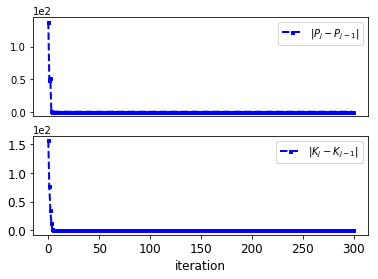

In [91]:
try:
    errP = np.trim_zeros(errP)
except:
    pass

try:
    errK = np.trim_zeros(errK)
except:
    pass

plt.figure(5)
plt.subplot(211)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.plot(errP[3,1:],'bs--',linewidth=linewidth, label=r'$|P_{j}-P_{j-1}|$', markersize=markersize)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.legend(fontsize=fontsize_legend, loc=0, ncol=1)
plt.subplot(212)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.plot(errK[3,:],'bs--',linewidth=linewidth, label=r'$|K_{j}-K_{j-1}|$', markersize=markersize)
plt.xlabel('iteration', fontsize=fontsize_xylabel)
plt.tick_params(labelsize=fontsize_ticks)
plt.legend(fontsize=fontsize_legend, loc=0, ncol=1)

In [29]:
Kstar

array([[100.        ,   3.3232921 ,   2.49685404,   0.12808484]])

Solve L for known system

In [39]:
S_ = [np.zeros((n,qm))] * (h+2)
for i in range(1, h+2):
    S_[i] = -A@X[i]
    
l_Alpha = h+n*qm+m*qm 
Alpha = np.zeros((n*2, l_Alpha))
b = np.zeros((n*2,1))
D_hat_ = vx*D
for i in range(2,h+2):
    Alpha[:n, i-2] = vec(S_[i]).squeeze()
    Alpha[n:, i-2] = vec(X[i]).squeeze()

Alpha[:qm*n, -1] = -np.kron(np.eye(qm), B).squeeze()
Alpha[2*n - n*qm:, h:h+n*qm] = -np.eye(n*qm)
b = np.vstack((vec(-S_[1] + D_hat_), -vec(X[1])))

A_11 = Alpha[:2*n-h, :h]
A_21 = Alpha[2*n-h:, :h]
A_12 = Alpha[:2*n-h, h:]
A_22 = Alpha[2*n-h:, h:]

b1 = b[h:]
b2 = b[:h]

M = -A_11@scipy.linalg.inv((A_21))@A_22 + A_12
N = -A_11@scipy.linalg.inv((A_21))@b2 + b1
Temp = np.zeros((n*qm+m*qm, n*qm+m*qm))
Temp[:n*qm,:n*qm] = np.kron(np.eye(qm), Q_bar)
Temp[n*qm:,n*qm:] = np.kron(np.eye(qm), R_bar)

#cvxopt.solvers.coneqp(P, q[, G, h[, dims[, A, b[, initvals[, kktsolver]]]]])
H = np.zeros((n*qm+m*qm, 1))
G = np.zeros((n*qm+m*qm, n*qm+m*qm))
sol = solvers.qp(matrix(Temp), matrix(np.zeros((n*qm+m*qm, 1))), matrix(G), matrix(H), matrix(M), matrix(N))
Xstar_ = sol['x'][:n*qm]
Ustar_ = sol['x'][n*qm:]
Lstar_ = Ustar_ + Kstar@Xstar_

     pcost       dcost       gap    pres   dres
 0:  2.3882e+04  2.3882e+04  5e+00  2e+00  3e-14
 1:  2.3882e+04  2.3882e+04  5e-02  2e-02  1e-14
 2:  2.3882e+04  2.3882e+04  5e-04  2e-04  2e-15
 3:  2.3882e+04  2.3882e+04  5e-06  2e-06  2e-15
 4:  2.3882e+04  2.3882e+04  5e-08  2e-08  8e-16
Optimal solution found.


In [31]:
Lstar_

array([[865.28756706]])

Solve L with ADP (system unknown)

In [122]:
# Repeat solving S(Xi) from (36): Learnt S
S = [np.zeros((n,qm))] * (h+2)
D_hat = (Vstar[0].T @ scipy.linalg.inv((Pstar))).T
for i in range(1, h+2):
    S[i] = (D_hat.T - (Vstar[i].T @ scipy.linalg.inv((Pstar)))).T

# Learnt B
B_ = scipy.linalg.inv((Pstar))@ Kstar.T @R

## Get M and N:
# Get Alpha and b
l_Alpha = h+n*qm+m*qm 
Alpha = np.zeros((n*2, l_Alpha))
b = np.zeros((n*2,1))

for i in range(2,h+2):
    Alpha[:n, i-2] = vec(S[i]).squeeze()
    Alpha[n:, i-2] = vec(X[i]).squeeze()

Alpha[:qm*n, -1] = -np.kron(np.eye(qm), B_).squeeze()
Alpha[2*n - n*qm:, h:h+n*qm] = -np.eye(n*qm)
b = np.vstack((vec(-S[1] + D_hat), -vec(X[1])))

A_11 = Alpha[:2*n-h, :h]
A_21 = Alpha[2*n-h:, :h]
A_12 = Alpha[:2*n-h, h:]
A_22 = Alpha[2*n-h:, h:]

b1 = b[h:]
b2 = b[:h]

M = -A_11@scipy.linalg.inv((A_21))@A_22 + A_12
N = -A_11@scipy.linalg.inv((A_21))@b2 + b1

# Get Xstar and Ustar:

Temp = np.zeros((n*qm+m*qm, n*qm+m*qm))
Temp[:n*qm,:n*qm] = np.kron(np.eye(qm), Q_bar)
Temp[n*qm:,n*qm:] = np.kron(np.eye(qm), R_bar)

#cvxopt.solvers.coneqp(P, q[, G, h[, dims[, A, b[, initvals[, kktsolver]]]]])
H = np.zeros((n*qm+m*qm, 1))
G = np.zeros((n*qm+m*qm, n*qm+m*qm))
sol = solvers.qp(matrix(Temp), matrix(np.zeros((n*qm+m*qm, 1))), matrix(G), matrix(H), matrix(M), matrix(N))
Xstar = sol['x'][:n*qm]
Ustar = sol['x'][n*qm:]
Lstar = Ustar + Kstar@Xstar

     pcost       dcost       gap    pres   dres
 0:  3.4312e+09  3.4313e+09  5e+00  2e+00  6e-07
 1:  3.4313e+09  3.4313e+09  5e-02  2e-02  1e-06
 2:  3.4313e+09  3.4313e+09  5e-04  2e-04  1e-06
 3:  3.4313e+09  3.4313e+09  5e-06  2e-06  3e-06
 4:  3.4313e+09  3.4313e+09  5e-08  2e-08  8e-07
 5:  3.4313e+09  3.4313e+09  5e-10  2e-10  3e-06
 6:  3.4313e+09  3.4313e+09  5e-12  2e-12  6e-07
 7:  3.4313e+09  3.4313e+09  5e-14  2e-14  1e-06
 8:  3.4313e+09  3.4313e+09  5e-16  2e-15  2e-06
 9:  3.4313e+09  3.4313e+09  5e-18  9e-16  2e-06
10:  3.4313e+09  3.4313e+09  5e-20  2e-15  2e-06
11:  3.4313e+09  3.4313e+09  5e-22  9e-16  2e-06
12:  3.4313e+09  3.4313e+09  5e-24  1e-16  2e-06
13:  3.4313e+09  3.4313e+09  5e-26  2e-15  2e-06
14:  3.4313e+09  3.4313e+09  5e-28  2e-15  2e-06
15:  3.4313e+09  3.4313e+09  5e-30  7e-16  2e-06
16:  3.4313e+09  3.4313e+09  5e-32  1e-16  2e-06
17:  3.4313e+09  3.4313e+09  5e-34  1e-15  8e-07
18:  3.4313e+09  3.4313e+09  5e-36  1e-16  2e-06
19:  3.4313e+09  3.43

In [93]:
Lstar

array([[875.9068284]])

In [126]:
#Test ADP contoller
time_simulation_adp = 10000
x_traj_after_learning = np.zeros((4, time_simulation_adp))
u_traj_after_learning = np.zeros((1, time_simulation_adp))
#x = np.random.normal(np.array([0.5, 0.5]), np.array([0.0, 0.0]))[:, np.newaxis]
w0 = W[0]
x_ = np.array([1, vx*math.sin(Pi/12), Pi/12, vx*w0])[:, np.newaxis]
i = 0
for w in W[:]:
    x_[-1,:] = vx*w
    for _ in range(time_simulation_adp//len(W[:])):
        x = x_
        u = -Kstar @ x + Lstar @ np.array([[w]])
        x_ = env(x, u, vx*np.array([[w0]]))
        x_traj_after_learning[:, i] = x_.reshape((4))
        u_traj_after_learning[:, i] = u.reshape((1))
        i += 1

In [127]:
##plots 
fontsize_xylabel = 12
fontsize_ticks = 12
fontsize_legend = 10
linewidth=2
markersize=3

Plots for state trajectory(Controler validation)

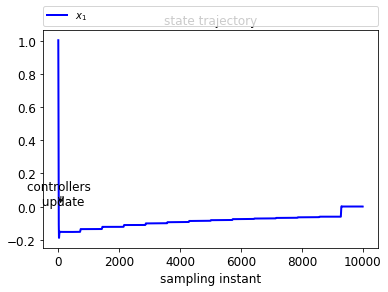

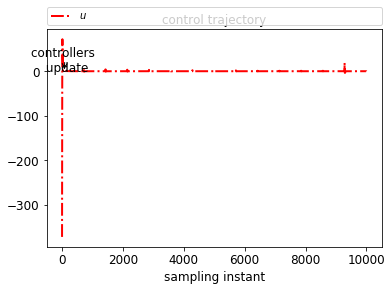

In [128]:
# x_traj_0_whole = np.concatenate((x_traj_0[:, np.newaxis], x_traj_after_learning[0,:][:, np.newaxis]), axis=0)
# x_traj_1_whole = np.concatenate((x_traj_1[:, np.newaxis], x_traj_after_learning[1,:][:, np.newaxis]), axis=0)
plt.figure(0)
plt.title('state trajectory')
plt.plot(x_traj_after_learning[0,:], linestyle='-', linewidth=linewidth, color='blue', label=r'${x}_1$')
#plt.plot(x_traj_1_whole, linestyle='-.', linewidth=linewidth, color='red', label=r'${x}_2$')
plt.xlabel('sampling instant', fontsize=fontsize_xylabel)
plt.tick_params(labelsize=fontsize_ticks)
plt.legend(fontsize=fontsize_legend, loc=0, ncol=1)
plt.annotate(
        'controllers \n update', ha='center', fontsize=fontsize_xylabel,
        xy=(time_max, 0.007), arrowprops=dict(arrowstyle='->'), xytext=(time_max+20, 0.007))
lgd = pylab.legend(fontsize=fontsize_legend,loc=3, mode="expand", bbox_to_anchor=(0., 1.02, 1., .102), 
                   ncol=4, borderaxespad=0.)
art = []
art.append(lgd)
#pylab.savefig("VI_x_traj.png", additional_artists=art, bbox_inches="tight",dpi=200)

plt.figure(1)
plt.title('control trajectory')
#plt.plot(x_traj_0_whole, linestyle='-', linewidth=linewidth, color='blue', label=r'${x}_1$')
plt.plot(u_traj_after_learning[0,:], linestyle='-.', linewidth=linewidth, color='red', label=r'${u}$')
plt.xlabel('sampling instant', fontsize=fontsize_xylabel)
plt.tick_params(labelsize=fontsize_ticks)
plt.legend(fontsize=fontsize_legend, loc=0, ncol=1)
plt.annotate(
        'controllers \n update', ha='center', fontsize=fontsize_xylabel,
        xy=(time_max, -0.3), arrowprops=dict(arrowstyle='->'), xytext=(time_max+20, -0.3))
lgd = pylab.legend(fontsize=fontsize_legend,loc=3, mode="expand", bbox_to_anchor=(0., 1.02, 1., .102), 
                   ncol=4, borderaxespad=0.)
art = []
art.append(lgd)